<a href="https://colab.research.google.com/github/rsonthal/challenge-iclr-2022/blob/main/rsonthal_xfcui/TreeEmbeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hyperbolic Embedding via Tree Learning
Authors: Rishi Sonthalia, Xinyue Cui

Partially supported by NSF DMS-2027277, and DMS-1952339

# 1 Introduction

Many different types of metric data can be represented in hyperbolic space with smaller distortion as compared to euclidean space. Such datasets usually have semantically rich hierarchies such as text [35], social and other forms of networks [7,9,25,26], and cell development trees [16]. Hyperbolic representations have also been seen to be useful for computer vision and other tasks [32,33,34]. Due to the success of these applications, recently there has been a great effort in developing hyperbolic versions of different neural networks - hyperbolic deep neural networks [4,24,39,46,47], hyperbolic convolutional neural networks [47,48], hyperbolic recurrent neural networks [39], hyperbolic transformers [40,47], and hyperbolic graph neural networks [42,43,45]. Other applications of hyperbolic representations and hyperbolic neural networks also include [21,22,23,27,28,30]. See surveys [31,49] for many more example applications.

Additionally, people have looked at extending hyperbolic embeddings beyond hyperbolic manifolds to other hyperbolic structures such as Hierarchical Hyperbolic Spaces [38]. Works such as [36,37] have proven that phylogenetic data live in these Hierarchical Hyperbolic Spaces.

To take advantage of hyperbolic representations, we need techniques to embed data into hyperbolic manifolds. Two different approaches have been taken to learning these embeddings. First, we learn these embeddings by solving an optimization problem. This could be done in a supervised or unsupervised manner. Second, we learn combinatorial structures that are then combinatorially embedded into the hyperbolic manifold.


## 1.1 Optimiation Based Methods. 

For the unsupervised method, we are given a distance matrix, or a distance matrix is extracted from the given data and then we set up an optimization problem that learns the embedding into the hyperbolic manifold. Concretely, let $D \in \mathbb{R}^{n \times n}$ be the distance matrix, let $y_i$ for $i = 1, \ldots, n$ be vectors in the hyperbolic manifold $\mathbb{H}^d$. Then we have a loss function $L := L(D, y_1, \ldots, y_n)$ that we want to minimize. Examples of such methods include [2,4,17,18,41]. 

Supervised methods learn embeddings using neural networks. One common example is to learn word embeddings. Works such as [50,51] present hyperbolic versions of standard word embedding techniques such as Word2Vec and GLoVe. [20] looks at embeddings graphs using a neural network. Another approach to learning hyperbolic embeddings via neural networks is to pick a random vector in $\mathbb{H}^d$ as the initial embedding and this embedding is optimized during the training of the neural network. 

However, such approaches tend to have a few common issues. 

    1) The optimization problem is non-convex and is very difficult to solve;
    2) the optimization procedure is unstable and requires a large number of bits to accurately represent; or
    3) the methods do not have any theoretical guarantees. 

The issue with the number of bits of precision will be a persistent issue for any technique that learns coordinates in the manifold.
    

## 1.2 Combinatorial Techniques. 

There are also two different combinatorial techniques. The first is to directly embed a given graph into a hyperbolic manifold [1,3,5,6] using a combinatorial algorithm. While some of these methods have had some success a lot of these methods are more theoretically motivated and very difficult to implement. 

Other methods exploit the tree-like structure [10,11,12,14] of hyperbolic space. For these methods, given a metric, we first learn a tree that approximates the given metric [13, 15, 29]. Then given this tree, we either treat the tree as the hyperbolic representation or embed the tree in a hyperbolic manifold using Sarkar's algorithm or an extension [19, 18]. This pipeline is shown in the following figure. 
<br>
<img src = 'https://drive.google.com/uc?id=16vFddEVgsUvjastWWLSuP8ORZruS2ADF'>

In this notebook, we would like to implement one such combinatorial method represented by the above pipeline. Specifically, we implement 

    1) The latest tree learning method TreeRep from [29]. This is an algorithm that given a tree metric reconstructs the tree structure or given a non-tree metric finds a tree structure that approximates this metric. 
    2) Sarkar's algorithm [19] for embeddings weighted trees into the Poincare disk. 

**The main reason we picked this method to implement is that it is a combinatorial method. Hyperbolic geometry has nice connections to combinatorial structures. While differential methods have plenty of standard implementations, there are fewer implementations of combinatorial methods. Combinatorial methods tend to have more rigorous theoretical guarantees and are faster.**


The structure of the notebook will be as follows

    1) First we present some background on hyperbolic geometry from the algebraic viewpoint.
    2) We present TreeRep and demonstrate how it can be used to construct trees from metrics.
    3) We present Sarkar's algorithm and demonstrate how it can be used to embed data into the Poincare disk. 
    4) We test the complete pipeline on real-world and synthetic datasets to demonstrate that we get embeddings with low distortion. 
 
Other implementations of the above algorithms exist. TreeRep has two prior implementations. The first is in Julia and can be found at [https://github.com/rsonthal/TreeRep] and the second is in C++ and can be found at [https://github.com/nalexai/hyperlib]. There are two prior implementations of Sarkar's algorithm as well. Again there are in Julia [https://github.com/HazyResearch/hyperbolics] and in C++ [https://github.com/nalexai/hyperlib]. Both implementations for both algorithms have python wrappers. But to the best of our knowledge, there does not exist a python version of the two algorithms. The Julia implementations are standalone implementations. While the C++ implementations are a part of an open-source package for hyperbolic neural networks. 


## 1.4 Related work

There is another family of work related to these methods. That is, the idea of approximating general metrics by trees. Note here we do not have a hyperbolic view of these metrics or the trees, just that trees are simple graphical structures. Such work includes [52,53,54].

The final area of related work is the notion of metric embeddings. See for more details [55]. 

# 2 Background

## 2.1 Models of Hyperbolic Manifold

The hyperboloid model $\mathbb{H}^k$ of the hyperbolic manifold is $ \displaystyle \mathbb{H}^k = \left\{ x \in \mathbb{R}^{k+1} : x_0 > 0, x_0^2 - \sum_{i=1}^k x_i^2 = 1\right\}. $

Here distances are given via 

$$ d(x,y) = \text{arccosh}\left(-\sum_{i=1}^n x_i y_i + x_{n+1}y_{n+1}\right) $$

For the hyperboloid model, we have nice formulas for the exponential and log maps. For example, the exponential map is given by

$$ \exp_x(v)  = \cosh(\|v\|_{\mathbb{H}})x + \sinh(\|v\|_{\mathbb{H}})\frac{v}{\|v\|_{\mathbb{H}}}, $$

where 

$$ \|x\|_\mathbb{H} = -x_0^2 + \sum_{i=1}^k x_i^2. $$

Another common model is the Poincare disk model. 

$$ \mathbb{H}^n = \{x \in \mathbb{R}^n : \|x\|_2 \le 1\}, $$

here distances are given by 
$$
	d(x,y) = \text{arccosh}\left(1 + 2\frac{\|x-y\|^2}{(1-\|x\|^2)(1-\|y\|^2)}\right).
$$

For the poincare disk model, it can be shown that the metric is conformal with the euclidean metric on the disk. That is, the metric matrix for the Poincare disk is a scalar multiple of the identity matrix. 





## 2.2 Gromov Hyperbolicity. 

Gromov introduced the notion of $\delta$ hyperbolicity [58] to define hyperbolic structure on certain groups. Let $X$ be any metric space. Let $d$ be the metric on $X$. Then $X$ is $\delta$ hyperbolic if, for all points $w, x, y, z$, we have that 

$$ (x,y)_w \le \min((x,z)_w, (y,z)_w)) - \delta, $$

where $(x,y)_w$ is the Gromov inner product of $x$ and $y$ with respect to the base point $w$. This can be calculated as follows. 

$$ (x,y)_w = \frac{1}{2}(d(x,w) + d(y,w) - d(x,y)). $$

Heuristically, we can think of this as the distance from $w$ to the geodesic connecting $x$ and $y$. Note if $\delta = 0$. This is exactly the case. Now it has been shown that the hyperbolic manifold is $\delta$ hyperbolic, for $\delta = \tanh^{-1}(1/\sqrt{2}) \approx 0.88$. One thing to note about $\delta$ is that it is not scale invariant. That is, if we scale our metric by $\lambda$, then the inner product gets scale by $\lambda$ and hence we would have to scale $\delta$ as well. 

Another way to understand the $\delta$ hyperbolicity conditions is via looking at the geodesic triangles in $X$. In particular, they should look as follows. 

<img src = 'https://drive.google.com/uc?id=1SUHUHdymnvev7EK1oWBi71nXEMFeJ3Kh'>


From this one can see that as $\delta \to 0$, our triangles look like graphs. In fact, it has been shown that a metric is 0-hyperbolic if and only if it came from a tree. 

# 3 Code 

First let us install and import of all the necessary libraries. Here we note which computation primitives from geomstats are used.

    1) We use the PoincareBall class. 
        a) We use the function for randomly sampling points.
        b) We use the function for projecting onto the manifold.
        c) We use the function for computing the exponential and the log.
    2) We use the Hyperboloid class.
        a) We use the function for converting from the ball to the hyperboloid model.
        b) We compute geodesics using the hyperboloid model.
        c) We use the function to convert from the hyperboloid model to the poincare disk.
    3) We use the PoincareBallMetric class
        a) We use the function for computing the distance between two points.
    4) We use the Graph class 
        a) We use this to represent to represent our external dataset CS Ph.D [56] so that we can use a method already implemented in geomstats (a comparison method) on this data set.
        b) We also use the karate graph dataset.
    5) We use the SymmetricMatrices class
        a) Our code implements a new class known as TreeSpace. We want this to be space of all trees on $n$ points. This extends the SymmetricMatrix class. The idea here was to represent points in TreeSpace by the $n \times n$ distance matrix.
    6) We use geomstats.visualization 
        a) We use this when plotting geodesics


In [ ]:
# Import the necessary packages
import sys

In [ ]:
%%capture
!{sys.executable} -m pip install networkx numpy scipy torch geomstats mpmath
!pip install -U matplotlib

import time
import numpy as np
import networkx as nx
import geomstats.backend as gs
from geomstats.geometry.poincare_ball import PoincareBallMetric
from geomstats.geometry.poincare_ball import PoincareBall
from geomstats.datasets.prepare_graph_data import Graph

In [ ]:
# Custom code
import TreeRepresentation # Has code for TreeRep
import embedding_mpmath # Has code for Sarkar's algorithm
import TreeSpace # Defines tree space 
import utilities
import prior # prior method already implemented using geomstats

import matplotlib.pyplot as plt

## 3.1 TreeRep - Reconstructing Trees. 


The first example that we look at is given a metric from a tree can we reconstruct the original tree from the metric. In the code below, we 

    1) use networkx to sample a random tree on $n$ nodes and then extract its metric. Lines 6 - 13.
    2) Reconstruct the tree using TreeRep. Line 14.
    3) Print the distortion for the learned tree. Line 15.

As we shall see from the output our average distortion (defined below) is small (should be less than $10^{-15}$). We then plot the original graph and the reconstructed graph side by side to show that we have recovered the original tree. Here the average distortion between two metrics $D_{tgt}, D_{learned}$ is given by 

$$ \frac{2}{n(n-1)} \sum_{i \neq j} \frac{|D_{tgt}(i,j) - D_{learned}(i,j)|}{D_{tgt}(i,j)}. $$

From the figure it is clear we have recovered the tree structure and from the distortion, it is clear that we have recovered the edge lengths as well. This matches with the theoretical guarantee from [29] which states that given a tree metric TreeRep recovers the tree exactly. 

### 3.1.1 Theoretical Gaurantees of TreeRep

**Theorem [29]** Given $(X,d)$, a $\delta$-hyperbolic metric space, and $n$ points $x_1, \ldots, x_n \in X$, TreeRep returns a tree $(T,d_T)$. In the case that $\delta = 0$, $d_T = d$, and $T$ has the fewest possible nodes. TreeRep has a worst case run time $O(n^2)$. Furthermore the algorithm is embarrassingly parallelizable.  

While the above is for the $\delta = 0$ for the $\delta > 0$, we have the following bound on the additive distortion. 

**Propositon [29]**  Given a $\delta$-hyperbolic metric $d$, the universal tree $T$ on $x,y,z$ and a fourth point $w$, when sorting $w$ into its zone ($zone_i(\pi x)$), TreeRep introduces an additive distortion of at most $\delta$ between $w$ and $\pi y, \pi z$.

Here the universal tree is the unique tree exactly representing any three points. While TreeRep doesn't have a global distortion bound as [13] does, but it is much faster. Hence we picked this algorithm to implement.

The distortion between the original metric and the reconstructed metric is:  1.2289318682667897e-16



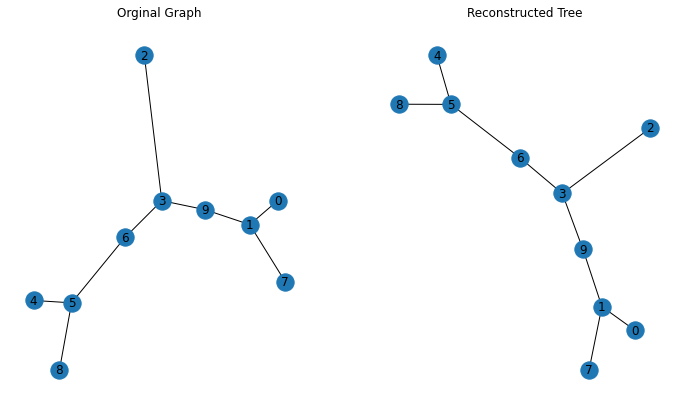

In [ ]:
n = 10
G = nx.random_tree(n)
for e in G.edges():
    G[e[0]][e[1]]['weight'] = gs.random.rand()*10
d = nx.algorithms.shortest_paths.dense.floyd_warshall(G)
D = gs.zeros((n,n))
for i in range(n):
  for j in range(n):
    D[i,j] = d[i][j]
T = TreeSpace.TreeSpace(d = D)
print("The distortion between the original metric and the reconstructed metric is: ",T.distortion())
print()

fig, ax = plt.subplots(1, 2, figsize=(12, 7))
nx.draw(G, ax = ax[0], with_labels = True, pos=nx.spring_layout(G, weight='weight'))
nx.draw(T.T.G, ax = ax[1], with_labels = True, pos=nx.spring_layout(T.T.G, weight='weight'))

ax[0].set_title("Orginal Graph")
ax[1].set_title("Reconstructed Tree");

Note that the TreeRep algorithm only requires a metric and does not require the original metric to come from a Tree. It could have come from anywhere. Here we show an example of an input that came from a complete graph and then a sparse graph. Note the complete graph is not a tree but defines a tree metric.

The distortion between the original metric and the reconstructed metric is:  0.0



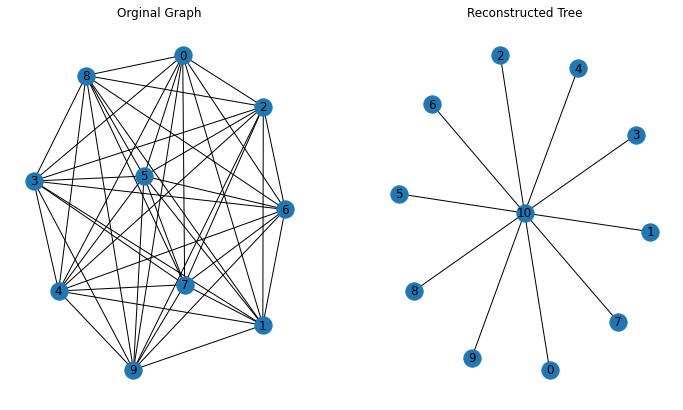

In [ ]:
n = 10
G = nx.complete_graph(n)
for e in G.edges():
    G[e[0]][e[1]]['weight'] = 1
d = nx.algorithms.shortest_paths.dense.floyd_warshall(G)
D = gs.zeros((n,n))
for i in range(n):
  for j in range(n):
    D[i,j] = d[i][j]
T = TreeSpace.TreeSpace(d = D)
print("The distortion between the original metric and the reconstructed metric is: ",T.distortion())
print()

fig, ax = plt.subplots(1, 2, figsize=(12, 7))
nx.draw(G, ax = ax[0], with_labels = True, pos=nx.spring_layout(G, weight='weight'))
nx.draw(T.T.G, ax = ax[1], with_labels = True, pos=nx.spring_layout(T.T.G, weight='weight'))

ax[0].set_title("Orginal Graph")
ax[1].set_title("Reconstructed Tree");

The distortion between the original metric and the reconstructed metric is:  0.14034582968925804



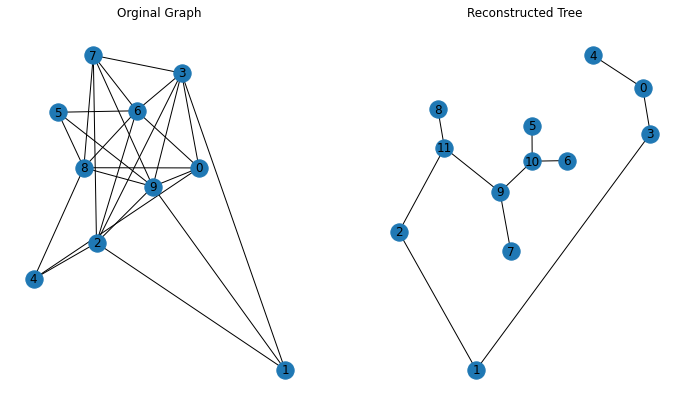

In [ ]:
n = 10
G = nx.gnp_random_graph(n,0.35)
for e in G.edges():
    G[e[0]][e[1]]['weight'] = gs.random.rand()*10
d = nx.algorithms.shortest_paths.dense.floyd_warshall(G)
D = gs.zeros((n,n))
for i in range(n):
  for j in range(n):
    D[i,j] = d[i][j]
T = TreeSpace.TreeSpace(d = D)
print("The distortion between the original metric and the reconstructed metric is: ",T.distortion())
print()

fig, ax = plt.subplots(1, 2, figsize=(12, 7))
nx.draw(G, ax = ax[0], with_labels = True, pos=nx.spring_layout(G, weight='weight'))
nx.draw(T.T.G, ax = ax[1], with_labels = True, pos=nx.spring_layout(T.T.G, weight='weight'))

ax[0].set_title("Orginal Graph")
ax[1].set_title("Reconstructed Tree");

In both cases, we see that TreeRep quickly outputs a tree with low distortion. It is important to note that TreeRep is a randomized algorithm. Hence if we run it again, as we do in the next cell, we will produce a different tree.

It is also important to note that even though our original data came from a graph, TreeRep does not know about this graph structure. In particular, TreeRep is not finding a subgraph that is a Tree. As we might see in the above (or below) examples, there are edges between nodes in the tree that do not exist in the original graph. 

The distortion between the original metric and the reconstructed metric is:  0.04822752123376535



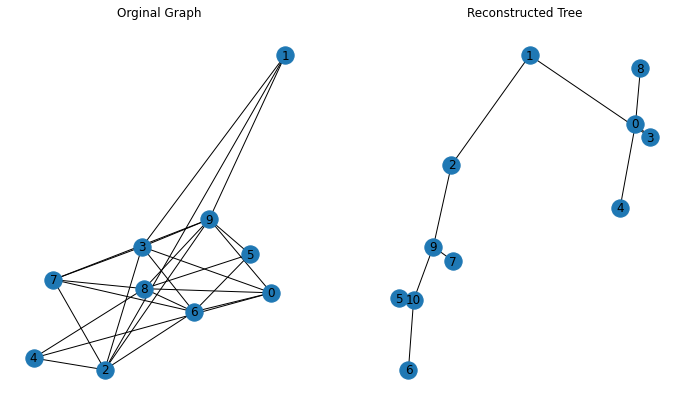

In [ ]:
T = TreeSpace.TreeSpace(d = D)
print("The distortion between the original metric and the reconstructed metric is: ",T.distortion())
print()

fig, ax = plt.subplots(1, 2, figsize=(12, 7))
nx.draw(G, ax = ax[0], with_labels = True, pos=nx.spring_layout(G, weight='weight'))
nx.draw(T.T.G, ax = ax[1], with_labels = True, pos=nx.spring_layout(T.T.G, weight='weight'))

ax[0].set_title("Orginal Graph")
ax[1].set_title("Reconstructed Tree");

### 3.1.2 Benchmarking Time Taken

Here we run some experiments to benchmark the time taken for this implementation to reconstruct a tree from a given tree metric. 

As we can see for a graph with 500 nodes, the implementation returns a tree in under 0.3 seconds. Note this is slower than the times reported in [29]. From [29] they can compute a tree on a graph with 800 nodes in under 0.1 seconds. This difference in speed may be due to 3 factors.

    1) The Julia implementation parallelizes certain steps. We do not. 
    2) The machine the code is being run on. 
    3) Julia is a faster language than python.

Text(0, 0.5, 'Time Taken in seconds')

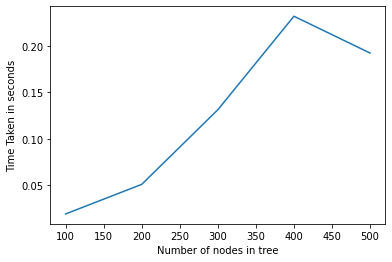

In [ ]:
num_n = 5
times = np.zeros(num_n)

for n in range(100,(num_n+1)*100,100):
  G = nx.random_tree(n)
  for e in G.edges():
      G[e[0]][e[1]]['weight'] = gs.random.rand()*10
  d = nx.algorithms.shortest_paths.dense.floyd_warshall(G)
  D = gs.zeros((n,n))
  for i in range(n):
    for j in range(n):
      D[i,j] = d[i][j]
  t0 = time.time()
  T = TreeSpace.TreeSpace(d = D)
  t1 = time.time()
  times[(n-100)//100] = t1-t0
plt.plot(range(100,(num_n+1)*100,100), times)
plt.xlabel("Number of nodes in tree")
plt.ylabel("Time Taken in seconds")

## 3.2 Sarkars Algorithm

Now that we have our method for learning trees. The next step in the pipeline is to embed the trees into the Poincare disk. For this, we shall use Sarkar's algorithm. Sarkar's algorithm [19] is a linear algorithm that given a weighted tree embeds into the Poincare disk. 

**Theorem [19]** If $D$ is a metric from a tree. Then for every $\epsilon > 0$, there exists a $\tau > 0$ such that $\tau D $ can be embedded into the Poincare disk with $\epsilon$ distortion. 

Note that decreasing $\epsilon$ results in increasing $\tau$. This pushes the embedding points closer to the edge of the disk and hence we could run into numerical precision issues. 

To begin let us take a simple tree $T$ and view its embedding in the Poincare disk for different values of $\tau$. We can also calculate the distortion between the embedded data points and the original metric. 

The distortion between the original metric and the reconstructed metric is:  4.265113596507117e-17



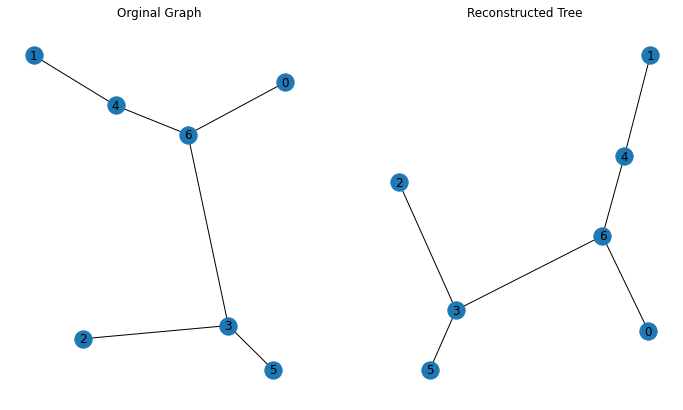

In [ ]:
n = 7
G = nx.random_tree(n)
for e in G.edges():
    G[e[0]][e[1]]['weight'] = gs.random.rand()
d = nx.algorithms.shortest_paths.dense.floyd_warshall(G)
D = gs.zeros((n,n))
for i in range(n):
  for j in range(n):
    D[i,j] = d[i][j]
T = TreeSpace.TreeSpace(d = D)
print("The distortion between the original metric and the reconstructed metric is: ",T.distortion())
print()

fig, ax = plt.subplots(1, 2, figsize=(12, 7))
nx.draw(G, ax = ax[0], with_labels = True, pos=nx.spring_layout(G, weight='weight'))
nx.draw(T.T.G, ax = ax[1], with_labels = True, pos=nx.spring_layout(T.T.G, weight='weight'))

ax[0].set_title("Orginal Graph")
ax[1].set_title("Reconstructed Tree");

Here we will directly vary $\tau$ to see how this affects the embedding both visually and in terms of the metric obtained. As we can see from the figure below, as we increase $\tau$ the data points get pushed more towards the boundary of the disk. We can also see that as $\tau$ increases, the distortion between the original metric and the embedded metric decreases. 

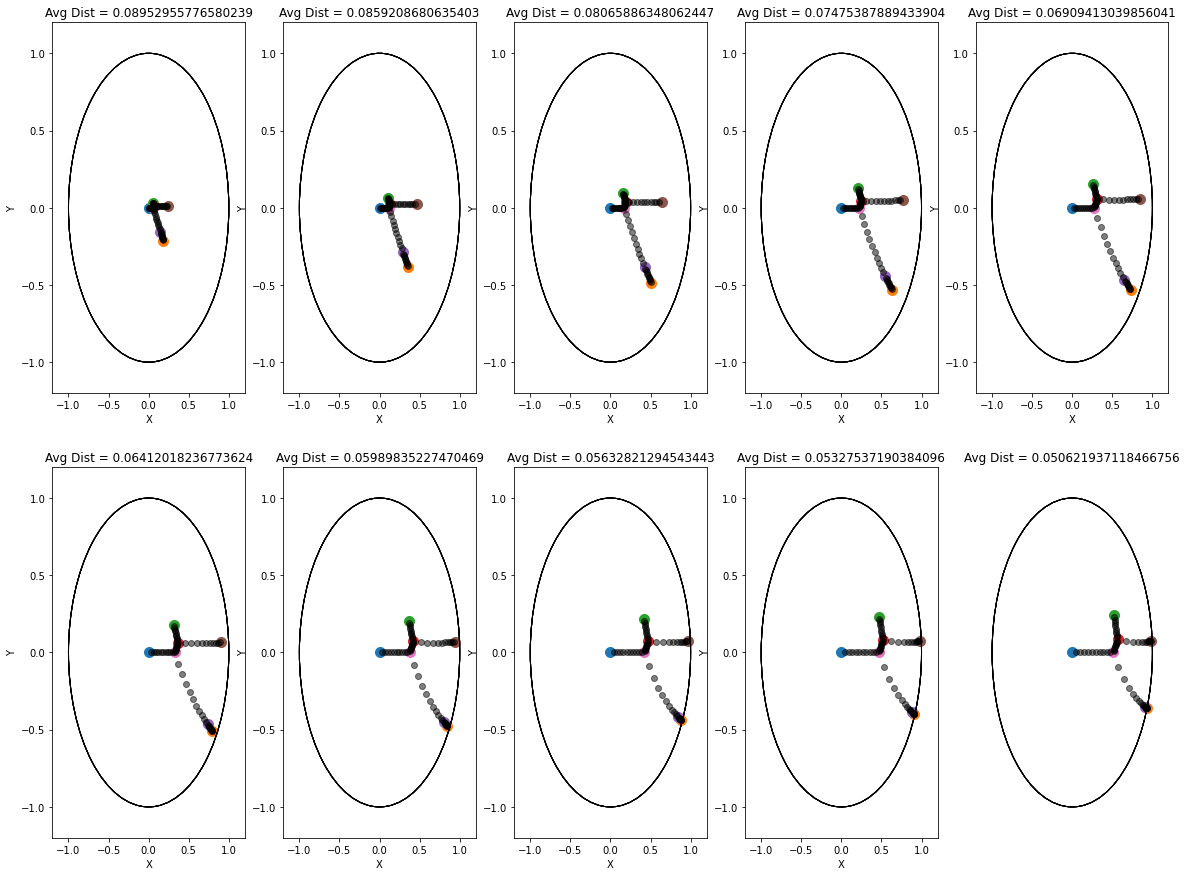

In [ ]:
T = TreeSpace.TreeSpace(d = D)
fig, ax = plt.subplots(2, 5, figsize=(20, 15))
for i in range(1,11):
  if i <= 5:
    idx1 = 0
    idx2 = i-1
  else:
    idx1 = 1
    idx2 = i-6
  T.embed_to_poincare_ball(tau = i/2)
  T.visualize(ax[idx1,idx2], tau = i/2)
  ax[idx1,idx2].set_title("Avg Dist = "+str(T.distortion("Input - embed")))

## 3.3 Testing on Synthetic test

We demonstrate the application of this pipline on two different tasks.

    1) Dimensionality reduction on hyperbolic manifold.
    2) Embeddings graphs into the Poincare disk.



### 3.3.1 Random Points on the hyperbolic manifold

For the task of dimensionality reduction, the idea is as follows. First, we take random points in a high-dimensional hyperbolic manifold. We then compute the metric and approximate this metric using a tree. Once we have a tree that approximates our given data, we can then embed it into 2 dimensional Poincare disk. 

Note this is a huge reduction in the dimensionality of the data. As we shall see, as seen in [29], that increasing the dimension lets us get better tree approximations! This is only possible due to the tree likeness of hyperbolic space. 

In [ ]:
ds = range(100,1001,100)
distort_tree = gs.zeros(10)
distort_embed = gs.zeros(10)
distort_embed2 = gs.zeros(10)
for d in ds:
  n = 200
  Hd = PoincareBall(d)
  HdMetric = PoincareBallMetric(d)

  X = Hd.random_point(n,1)

  D = gs.zeros((n,n))
  for i in range(n):
    for j in range(i):
      D[i,j] = HdMetric.dist(X[i,:], X[j,:])
      D[j,i] = D[i,j]

  t0 = time.time()
  T = TreeSpace.TreeSpace(d = D)
  t1 = time.time()

  lt = t1-t0

  t0 = time.time()
  T.embed_to_poincare_ball(tau = 1)
  t1 = time.time()

  distort_tree[d//100 - 1] =  T.distortion()
  distort_embed[d//100 - 1] =  T.distortion("Input - embed")

  T.embed_to_poincare_ball(tau = 2)
  distort_embed2[d//100 - 1] =  T.distortion("Input - embed")

  print("Reducing from dimension ", d)
  print("The distortion between the original metric and the tree metric is: ",distort_tree[d//100 - 1])
  print("Tree Learned in ", lt, " seconds")
  print("The distortuon between the original metric and the embedded metric is: ",distort_embed[d//100 - 1])
  print("Embedding learned in ",t1-t0, " seconds")
  print()

Reducing from dimension  100
The distortion between the original metric and the tree metric is:  0.09021658532963986
Tree Learned in  0.03248405456542969  seconds
The distortuon between the original metric and the embedded metric is:  0.28426558498013893
Embedding learned in  0.1597592830657959  seconds

Reducing from dimension  200
The distortion between the original metric and the tree metric is:  0.04430112809327273
Tree Learned in  0.0335695743560791  seconds
The distortuon between the original metric and the embedded metric is:  0.26861559045295613
Embedding learned in  0.1563253402709961  seconds

Reducing from dimension  300
The distortion between the original metric and the tree metric is:  0.027697462532402586
Tree Learned in  0.04461407661437988  seconds
The distortuon between the original metric and the embedded metric is:  0.2594759381964142
Embedding learned in  0.15378904342651367  seconds

Reducing from dimension  400
The distortion between the original metric and the tr

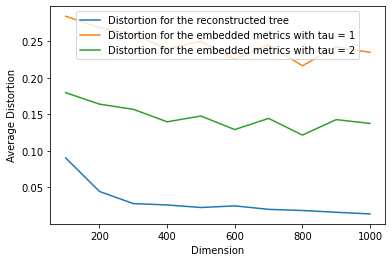

In [ ]:
plt.plot(ds, distort_tree, label = "Distortion for the reconstructed tree")
plt.plot(ds, distort_embed, label = "Distortion for the embedded metrics with tau = 1")
plt.plot(ds, distort_embed2, label = "Distortion for the embedded metrics with tau = 2")
plt.legend()
plt.xlabel("Dimension")
plt.ylabel("Average Distortion");

Here, the difference between the embedded metric distortion and the tree distortion is due to the scaling factor $\tau$ for Sarkar's algorithm. However, it follows the same trend of decreasing as the dimension increases. 

**Thus, it is easier to dimensionality reduction for higher-dimensional hyperbolic manifolds, using this pipeline.**

### 3.3.2 Random Sparse Graphs

The second application is embedding data into the Poincare disk. For this example, we shall take random dense graphs. We will then approximate the metric using a tree and then embed the tree into the Poincare disk using Sarkar's algorithm. 

In [ ]:
Ns = range(100,401,100)

distort_tree = gs.zeros(4)
distort_embed = gs.zeros(4)
distort_embed2 = gs.zeros(4)

for n in Ns:
  G = nx.gnp_random_graph(n,0.5)
  for e in G.edges():
      G[e[0]][e[1]]['weight'] = gs.random.rand()*10
  d = nx.algorithms.shortest_paths.dense.floyd_warshall(G)
  D = gs.zeros((n,n))
  for i in range(n):
    for j in range(n):
      D[i,j] = d[i][j]

  t0 = time.time()
  T = TreeSpace.TreeSpace(d = D)
  t1 = time.time()

  lt = t1-t0

  t0 = time.time()
  T.embed_to_poincare_ball(tau = 1)
  t1 = time.time()

  distort_tree[n//100 - 1] =  T.distortion()
  distort_embed[n//100 - 1] =  T.distortion("Input - embed")

  T.embed_to_poincare_ball(tau = 2)
  distort_embed2[n//100 - 1] =  T.distortion("Input - embed")

  print("GNP graph with n = ", n)
  print("The distortion between the original metric and the tree metric is: ",distort_tree[n//100 - 1])
  print("Tree Learned in ", lt, " seconds")
  print("The distortuon between the original metric and the embedded metric is: ",distort_embed[n//100 - 1])
  print("Embedding learned in ",t1-t0, " seconds")
  print()


GNP graph with n =  100
The distortion between the original metric and the tree metric is:  0.7796489469051644
Tree Learned in  0.062232255935668945  seconds
The distortuon between the original metric and the embedded metric is:  0.4176187175929528
Embedding learned in  0.3473477363586426  seconds

GNP graph with n =  200
The distortion between the original metric and the tree metric is:  0.3633261369730757
Tree Learned in  0.026187896728515625  seconds
The distortuon between the original metric and the embedded metric is:  0.4177200181172195
Embedding learned in  0.10331130027770996  seconds

GNP graph with n =  300
The distortion between the original metric and the tree metric is:  0.53945250174477
Tree Learned in  0.052848100662231445  seconds
The distortuon between the original metric and the embedded metric is:  0.4201913931529258
Embedding learned in  0.18136906623840332  seconds

GNP graph with n =  400
The distortion between the original metric and the tree metric is:  0.726275

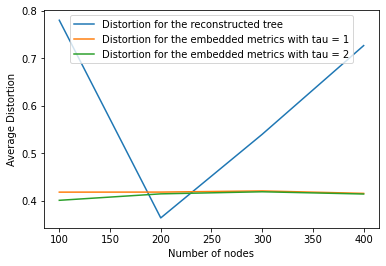

In [ ]:
plt.plot(Ns, distort_tree, label = "Distortion for the reconstructed tree")
plt.plot(Ns, distort_embed, label = "Distortion for the embedded metrics with tau = 1")
plt.plot(Ns, distort_embed2, label = "Distortion for the embedded metrics with tau = 2")
plt.legend()
plt.xlabel("Number of nodes")
plt.ylabel("Average Distortion");

Here we do not see any trends as $n$ increases. This is probably due to the fact that the hyperbolicity or the tree-likeness of the graph depends on the instant in consideration. 

Here we also note a surprising phenomenon, where the error due to the embeddings from Sarkar's algorithm actually produces an embedding whose distortion is lower than that of the tree. 

### 3.3.3 Synthetic Example Takeaways

The two synthetic examples above, while simple demonstrate the main advantage of this method. Namely its speed. As we see, from the above examples this method produces good quality hyperbolic embeddings very quickly!

Once we have the embedding of the data that captures the geometry of the data. Then we can perform any downstream task on the data using a hyperbolic neural network.

## 3.4 Testing it on real-world data

We will now test the pipeline on two different real-world data sets.

 1) Karate Dataset
 2) CS Ph.D. dataset

The karate dataset is a common dataset for graph learning tasks. The nodes represent people at a karate dojo and the edges represent interactions. The other dataset is a citation network. 

The karate dataset is small and only has 34 nodes. However, the CS Ph.D. dataset is bigger and has 1025 nodes. 

In this section, we shall also compare this pipeline against one that already has a geomstats [implementation](https://github.com/geomstats/geomstats/blob/master/notebooks/usecase_graph_embedding_and_clustering_in_hyperbolic_space.ipynb). This method is an example of the unsupervised optimization technique detailed in the introduction. 

we shall see that our pipeline outputs a hyperbolic representation much faster (< 0.5 seconds versus > 25 minutes for the CS Ph.D. data). Not only does it output the representation much faster the quality of the representation is better. 

Note in this example, we also identify an issue. This is namely that coordinate representations in hyperbolic space require a high number of bits of precision. Our embedding code uses mpmath to increase the precision of the arithmetic calculations. However, to use the geomstats primitives, we need to convert to a standard double. When doing so, we lose precision. Namely increasing $\tau$ should result in an embedding with lower distortion. However, due to numerical errors, it degrades the quality. This is due to the fact that small $\ell_2$ changes near the boundary result in big differences in the hyperbolic distance.

### 3.4.1 Karate Graph

In [ ]:
from geomstats.datasets.utils import load_karate_graph

In [ ]:
karate_graph = load_karate_graph()
kg = nx.Graph()

for k in karate_graph.edges:
  N = karate_graph.edges[k]
  for v in N:
    kg.add_edge(k,v)

The distortion between the original metric and the reconstructed metric is:  0.32937091503267985
Tree Learned in  0.00799560546875  seconds



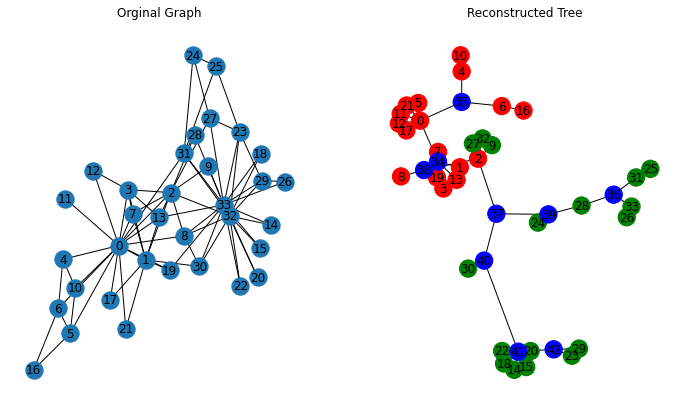

In [ ]:
n = karate_graph.n_nodes
d = nx.algorithms.shortest_paths.dense.floyd_warshall(kg)
D = gs.zeros((n,n))
for i in range(n):
  for j in range(n):
    D[i,j] = d[i][j]
t0 = time.time()
T = TreeSpace.TreeSpace(d = D)
t1 = time.time()

lt = t1-t0
print("The distortion between the original metric and the reconstructed metric is: ",T.distortion())
print("Tree Learned in ", lt, " seconds")
print()

color_map = []
labels = karate_graph.labels

for i in range(34):
  if labels[i][0] == 1:
    color_map.append("red")
  else:
    color_map.append("green")

N = T.T.G.number_of_nodes()
for i in range(34,N):
  color_map.append("blue")

fig, ax = plt.subplots(1, 2, figsize=(12, 7))
nx.draw(kg, ax = ax[0], with_labels = True, pos=nx.spring_layout(kg, weight='weight'))
nx.draw(T.T.G, ax = ax[1], with_labels = True, pos=nx.spring_layout(T.T.G), node_color = color_map)

ax[0].set_title("Orginal Graph")
ax[1].set_title("Reconstructed Tree");

We should see that TreeRep learns a tree that clusters the nodes by its labels. This is even though the method does not know the true labels. However, since TreeRep doesn't always do this (since it is randomized) we highlight one such run below. However, the quality of clustering on average should be good. 

<img src ='https://drive.google.com/uc?id=1cGFqMvkPFNv6lqux1N04WwYwmVnO6Ok1'>

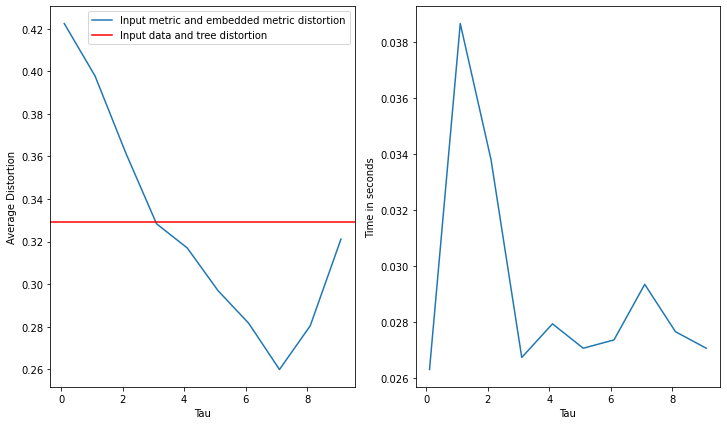

In [ ]:
distorts = gs.zeros(10)
taus = gs.zeros(10)

average_embed_time = gs.zeros(10)

for i in range(1,101,10):
  t0 = time.time()
  T.embed_to_poincare_ball(tau = i/10)
  t1 = time.time()
  average_embed_time[i//10] = t1-t0
  distorts[i//10] = T.distortion("Input - embed")
  taus[i//10] = i/10


fig, ax = plt.subplots(1, 2, figsize=(12, 7))
ax[0].plot(taus, distorts, label = "Input metric and embedded metric distortion")
ax[0].axhline(y = T.distortion(), color = "red", label = "Input data and tree distortion")
ax[0].set_xlabel("Tau")
ax[0].set_ylabel("Average Distortion")
ax[0].legend()

ax[1].plot(taus, average_embed_time)
ax[1].set_xlabel("Tau")
ax[1].set_ylabel("Time in seconds");

The plot on the left shows how the distortion of the embedded metric changes as we change $\tau$. Note as $\tau \to \infty$ we should have that the blue curve asymptotes to the red line (the distortion for the tree learned). However, we see that it can dip below and even start diverging as $\tau$ increases. This is due to the fact that we are running into numerical issues at large $\tau$.

The graph on the right has the running time for Sarkar's algorithm. Thus, we can see that we can produce a good quality embedding of the data very quickly using this pipeline.

-----------

We now compare this against an optimization method that has been implemented previously in geomstats. This implementation is from an example use case of the geomstats library [https://github.com/geomstats/geomstats/blob/master/notebooks/usecase_graph_embedding_and_clustering_in_hyperbolic_space.ipynb]



In [ ]:
karate_graph = load_karate_graph()
embeddings = prior.compute(karate_graph)

100%|██████████| 100/100 [00:48<00:00,  2.06it/s]

Optimization done in  48.45140838623047  seconds


In [ ]:
METRIC = PoincareBallMetric(2)
P2 = PoincareBall(2)

n = karate_graph.n_nodes
distances = gs.zeros((n,n))
for i in range(n):
  for j in range(i):
    distances[i,j] = METRIC.dist(embeddings[i,:], embeddings[j,:])
    distances[j,i] = distances[i,j]

In [ ]:
D_new = distances
D_old = D

dist = 0
for i in range(n):
  for j in range(i):
    dist += gs.abs(D_new[i,j]-D_old[i,j])/D_old[i,j]
2*dist/(n*(n-1))

0.30265848600938633

Here we see that the optimization based method produced a representation that has low distortion. But it took significantly longer (1 minute) than the combinatorial method (less than 0.05 seconds). Further, the best quality representation learned by the combinatorial method is lower than of the optimization based method. Hence because of the difference in speed, we can multiple runs of the combinatorial method and pick the best representation that it finds. 

### 3.4.2 CS Ph.D. Graph. 

This is a bigger example that better highlights the advantages of the new method. Note this graph is unlabelled. Also due to the size of the graph, we do not plot the graph.

In [ ]:
cs_graph = Graph("CSphd.csv", None)
cs = nx.Graph()

for k in cs_graph.edges:
  N = cs_graph.edges[k]
  for v in N:
    cs.add_edge(k,v)

In [ ]:
n = cs_graph.n_nodes

d = nx.algorithms.shortest_paths.dense.floyd_warshall(cs)
D = gs.zeros((n,n))
for i in range(n):
  for j in range(n):
    D[i,j] = d[i][j]
t0 = time.time()
T = TreeSpace.TreeSpace(d = D)
t1 = time.time()

lt = t1-t0
print("The distortion between the original metric and the reconstructed metric is: ",T.distortion())
print("Tree Learned in ", lt, " seconds")
print()

The distortion between the original metric and the reconstructed metric is:  0.13400567349136436
Tree Learned in  0.2785489559173584  seconds



Text(0, 0.5, 'Time in seconds')

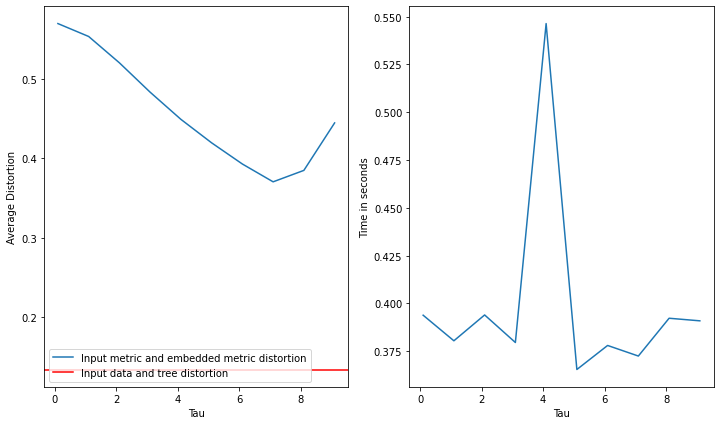

In [ ]:
distorts = gs.zeros(10)
taus = gs.zeros(10)

average_embed_time = gs.zeros(10)

for i in range(1,101,10):
  t0 = time.time()
  T.embed_to_poincare_ball(tau = i/50)
  t1 = time.time()
  average_embed_time[i//10] = t1-t0
  distorts[i//10] = T.distortion("Input - embed")
  taus[i//10] = i/10


fig, ax = plt.subplots(1, 2, figsize=(12, 7))
ax[0].plot(taus, distorts, label = "Input metric and embedded metric distortion")
ax[0].axhline(y = T.distortion(), color = "red", label = "Input data and tree distortion")
ax[0].set_xlabel("Tau")
ax[0].set_ylabel("Average Distortion")
ax[0].legend()

ax[1].plot(taus, average_embed_time)
ax[1].set_xlabel("Tau")
ax[1].set_ylabel("Time in seconds")

In [ ]:
cs_graph = Graph("CSphd.csv", None)
embeddings = prior.compute(cs_graph)

100%|██████████| 100/100 [24:06<00:00, 14.47s/it]

Optimization done in  1446.9963014125824  seconds


In [ ]:
METRIC = PoincareBallMetric(2)
P2 = PoincareBall(2)

distances = gs.zeros((n,n))
for i in range(n):
  for j in range(i):
    distances[i,j] = METRIC.dist(embeddings[i,:], embeddings[j,:])
    distances[j,i] = distances[i,j]

In [ ]:
D_new = distances
D_old = D

dist = 0
for i in range(n):
  for j in range(i):
    dist += gs.abs(D_new[i,j]-D_old[i,j])/D_old[i,j]
2*dist/(n*(n-1))

0.7033688119237426

Here we see that despite taking over 27 minutes. we have an average distortion that is worse than the one produced by the combinatorial method.

# 4 Conclusion

Hyperbolic representation learning has grown in importance over the last 5 years with many applications taking advantage of hyperbolic geometry. 

In this notebook, we demonstrate how one such pipeline for representing hyperbolic data can be used. Specifically, we look at a combinatorial approach for embedding the data. We show that using this approach, we can quickly learn low distortion and low dimensional representations. 

We contrast this with the optimization based methods. These take much longer and do not necessarily produce better quality results. However, standard libraries only have implementations for optimization based methods. Thus, presenting the need for combinatorial implementations. 

We also highlight an issue, with using coordinates to represent points in the hyperbolic manifold. Namely, such representations require a large number of bits of precision. A possible fix is given in [57]. This is again a combinatorial fix.

# Bibliograph

[1] Thomas Blasius, Tobias Friedrich, Anton Krohmer, Soren Laue, Anton Krohmer, Soren Laue, Tobias Friedrich, and Thomas Blasius. 2018. Efficient Embedding of Scale-Free Graphs in the Hyperbolic Plane. IEEE/ACM Trans. Netw. 26, 2 (April 2018), 920–933. DOI:https://doi.org/10.1109/TNET.2018.2810186 
 
 [2] Cvetkovski, Andrej and Crovella, Mark (2016) "Multidimensional Scaling in the Poincaré disk," Applied Mathematics & Information Sciences: Vol. 10 : Iss. 1 , Article 12. 
 DOI: http://dx.doi.org/10.18576/amis/100112 
 Available at: https://dc.naturalspublishing.com/amis/vol10/iss1/12 
 
 [3] Kevin Verbeek and Subhash Suri. 2014. Metric Embedding, Hyperbolic Space, and Social Networks. In Proceedings of the thirtieth annual symposium on Computational geometry (SOCG'14). Association for Computing Machinery, New York, NY, USA, 501–510. DOI:https://doi.org/10.1145/2582112.2582139 
 
 [4] Jörg A Walter, H-MDS: a new approach for interactive visualization with multidimensional scaling in the hyperbolic space, Information Systems, Volume 29, Issue 4, 2004, Pages 273-292, ISSN 0306-4379, https://doi.org/10.1016/j.is.2003.10.002. 
 
 [5] R. Kleinberg. 2007. Geographic Routing Using Hyperbolic Space. In Proceedings of the IEEE INFOCOM 2007 - 26th IEEE International Conference on Computer Communications. IEEE Computer Society, USA, 1902–1909. DOI:https://doi.org/10.1109/INFCOM.2007.221 
 
 [6] R. Krauthgamer and J. R. Lee, "Algorithms on negatively curved spaces," 2006 47th Annual IEEE Symposium on Foundations of Computer Science (FOCS'06), 2006, pp. 119-132, doi: 10.1109/FOCS.2006.9. 
 
 [7] Krioukov D, Papadopoulos F, Vahdat A, Boguñá M. Curvature and temperature of complex networks. Phys Rev E Stat Nonlin Soft Matter Phys. 2009 Sep;80(3 Pt 2):035101. doi: 10.1103/PhysRevE.80.035101. Epub 2009 Sep 23. PMID: 19905164. 
 
 [8] A. Cvetkovski and M. Crovella, "Hyperbolic Embedding and Routing for Dynamic Graphs," IEEE INFOCOM 2009, 2009, pp. 1647-1655, doi: 10.1109/INFCOM.2009.5062083. 
 
 [9] Y. Shavitt and T. Tankel, "Hyperbolic Embedding of Internet Graph for Distance Estimation and Overlay Construction," in IEEE/ACM Transactions on Networking, vol. 16, no. 1, pp. 25-36, Feb. 2008, doi: 10.1109/TNET.2007.899021. 
 
 [10] Matthias Hamann. On the Tree-Likeness of Hyperbolic Spaces. Mathematical Proceedings of the Cambridge Philosophical Society, 164(2):345–361, 2018. doi: 10.1017/ S0305004117000238. 
 
 [11] Anna Dyubina and Iosif Polterovich. Explicit Constructions of Universal R-Trees and Asymptotic Geometry of Hyperbolic Spaces. Bulletin of the London Mathematical Society, 33 (6):727?734, Nov 2001. 
 
 [12] M.Bonk and O.Schramm. Embeddings of Gromov Hyperbolic Spaces. Geometric & Functional Analysis GAFA, 10(2):266–306, Jun 2000. 
 
 [13] Ittai Abraham, Mahesh Balakrishnan, Fabian Kuhn, Dahlia Malkhi, Venugopalan Ramasubramanian, and Kunal Talwar. Reconstructing Approximate Tree Metrics. In Proceedings of the Twenty-sixth Annual ACM Symposium on Principles of Distributed Computing, PODC ’07, pages 43–52, New York, NY, USA, 2007. ACM. 
 
 [14] M.R. Bridson and A. Häfliger. Metric Spaces of Non-Positive Curvature. Grundlehren der mathematischen Wissenschaften. Springer Berlin Heidelberg, 2013. ISBN 9783662124949. 
 
 [15] Victor Chepoi, Feodor Dragan, Bertrand Estellon, Michel Habib, and Yann Vaxès. Diameters, Centers, and Approximating Trees of δ-Hyperbolic Geodesic Spaces and Graphs. In Proceedings of the Twenty-fourth Annual Symposium on Computational Geometry, SCG ’08, pages 59–68, New York, NY, USA, 2008. ACM. 
 
 [16] Anna Klimovskaia, David Lopez-Paz, Léon Bottou, and Maximilian Nickel. Poincaré Maps for Analyzing complex Hierarchies in Single-Cell Data. bioRxiv, 2019. doi: 10.1101/689547. 
 
 [17] Maximilian Nickel and Douwe Kiela. Poincaré Embeddings for Learning Hierarchical Representations. In NIPS, 2017. 
 
 [18] Frederic Sala, Chris De Sa, Albert Gu, and Christopher Re. Representation Tradeoffs for Hy- perbolic Embeddings. Proceedings of the 35th International Conference on Machine Learning, pages 4460–4469, July 2018. 
 
 [19] Rik Sarkar. Low Distortion Delaunay Embedding of Trees in Hyperbolic Plane. In Proceedings of the 19th International Conference on Graph Drawing, GD’11, pages 355–366, Berlin, Heidelberg, 2012. Springer-Verlag. 
 
 [20] B. P. Chamberlin, J. Clough, and M. P. Deisenroth, "Neural embeddings of graphs in hyperbolic space", arXiv 2017
 
 [21] M. E. Newman, “Power laws, pareto distributions and zipf’s law,” Contemporary physics, 2005.

 [22] H. W. Lin and M. Tegmark, “Critical behavior in physics and probabilistic formal languages,” Entropy, 2017.

 [23] K. Katayama and E. W. Maina, “Indexing method for hierarchical graphs based on relation among interlacing sequences of eigenvalues,” Journal of information processing, 2015.

 [24] R. Shimizu, Y. Mukuta, and T. Harada, “Hyperbolic neural networks++,” 2021.
 
 [25] M. Boguna ́, F. Papadopoulos, and D. Krioukov, “Sustaining the internet with hyperbolic mapping,” Nature communications, 2010.

 [26] B. Tadic ́, M. Andjelkovic ́, and M. Sˇuvakov, “Origin of hyperbolicity in brain-to-brain coordination networks,” Frontiers in Physics, 2018.
 
 [27] G.Garcia-Pe ́rez,M.Bogun ̃a ́,A.Allard,andM.A ́.Serrano,“Thehidden hyperbolic geometry of international trade: World trade atlas 1870– 2013,” Scientific reports, 2016.

 [28] M. Keller-Ressel and S. Nargang, “The hyperbolic geometry of financial networks,” Scientific reports, 2021.
 
 [29] Tree! I am no Tree! I am a Low Dimensional Hyperbolic Embedding. 2020 Neural Information Processing Symposium (Neurips 2020)
Rishi Sonthalia, Anna Gilbert

 [30] E. Begelfor and M. Werman, “The world is not always flat or learning curved manifolds,” School of Engineering and Computer Science, Hebrew University of Jerusalem., Tech. Rep, 2005.

 [31] M. M. Bronstein, J. Bruna, Y. LeCun, A. Szlam, and P. Vandergheynst, “Geometric deep learning: going beyond euclidean data,” IEEE Signal Processing Magazine, 2017.
 
 [32] B. P. Chamberlain, S. R. Hardwick, D. R. Wardrope, F. Dzogang, F. Daolio, and S. Vargas, “Scalable hyperbolic recommender systems,” CoRR, 2019.

 [33] P. Kolyvakis, A. Kalousis, and D. Kiritsis, “Hyperkg: hyperbolic knowledge graph embeddings for knowledge base completion,” arXiv, 2019.

 [34] V. Khrulkov, L. Mirvakhabova, E. Ustinova, I. Oseledets, and V. Lempit- sky, “Hyperbolic image embeddings,” in Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition, 2020.
 
 [35] Bhuwan Dhingra, Christopher J. Shallue, Mohammad Norouzi, Andrew M. Dai, and George E. Dahl. Embedding Text in Hyperbolic Spaces, 2018.
 
 [36] Louis J. Billera, Susan P. Holmes, and Karen Vogtmann. Geometry of the space of phylogenetic trees. Advances in Applied Mathematics, 27(4):733–767, 2001. ISSN 0196-8858. doi: https:// doi.org/10.1006/aama.2001.0759. URL https://www.sciencedirect.com/science/ article/pii/S0196885801907596.
 
 [37] Katherine St John. Review paper: The shape of phylogenetic treespace. Systematic Biology, 66:e83 – e94, 2017.
 
 [38] CubeRep: Learning Relations Between Different Views of Data. 
 
 [39] O. Ganea, G. Be ́cigneul, and T. Hofmann, “Hyperbolic neural networks,” Advances in neural information processing systems, 2018.

 [40] C. Gulcehre, M. Denil, M. Malinowski, A. Razavi, R. Pascanu, K. M. Hermann, P. Battaglia, V. Bapst, D. Raposo, A. Santoro et al., “Hyperbolic attention networks,” arXiv, 2018.

 [41] M. Nickel and D. Kiela, “Learning continuous hierarchies in the lorentz model of hyperbolic geometry,” Proceedings of the 35-th International Conference on Machine Learning, PMLR, 2018.

 [42] Q. Liu, M. Nickel, and D. Kiela, “Hyperbolic graph neural networks,” in Advances in Neural Information Processing Systems, 2019.

 [43] I. Chami, Z. Ying, C. Re ́, and J. Leskovec, “Hyperbolic graph convolutional neural networks,” in Advances in neural information processing systems, 2019.

 [44] W. Peng, J. Shi, Z. Xia, and G. Zhao, “Mix dimension in poincare ́ geometry for 3d skeleton-based action recognition,” in Proceedings of the 28th ACM International Conference on Multimedia, 2020.

 [45] G. Bachmann, G. Be ́cigneul, and O. Ganea, “Constant curvature graph convolutional networks,” in International Conference on Machine Learning. PMLR, 2020.

 [46] D. J. Rezende, G. Papamakarios, S. Racaniere, M. S. Albergo, G. Kanwar, P. E. Shanahan, and K. Cranmer, “Normalizing flows on tori and spheres,” Proceedings of the 37th International Conference on Machine Learning, 2020.
 
 [47] Chen, W., Han, X., Lin, Y., Zhao, H., Liu, Z., Li, P., Sun, M., & Zhou, J. (2021). Fully Hyperbolic Neural Networks. ArXiv, abs/2105.14686.
 
 [48] Lensink, K., Haber, E., & Peters, B. (2019). Fully Hyperbolic Convolutional Neural Networks. ArXiv, abs/1905.10484.

 [49] Peng, W., Varanka, T., Mostafa, A., Shi, H., & Zhao, G. (2021). Hyperbolic Deep Neural Networks: A Survey. IEEE transactions on pattern analysis and machine intelligence, PP.
 
 [50] Leimeister, M., & Wilson, B.J. (2018). Skip-gram word embeddings in hyperbolic space. ArXiv, abs/1809.01498.
 
 [51] Tifrea, A., Bécigneul, G., & Ganea, O. (2019). Poincaré GloVe: Hyperbolic Word Embeddings. ArXiv, abs/1810.06546.

 [52] Yair Bartal. On Approximating Arbitrary Metrics by Tree Metrics. In Proceedings of the Thirtieth Annual ACM Symposium on Theory of Computing, STOC ’98, pages 161–168, New York, NY, USA, 1998. ACM. ISBN 0-89791-962-9.

 [53] Noga Alon, Richard M. Karp, David Peleg, and Douglas West. A graph-theoretic game and its application to the k-server problem. SIAM J. Comput., 24(1):78–100, February 1995. ISSN 0097-5397. doi: 10.1137/S0097539792224474. URL https://doi.org/10.1137/ S0097539792224474.

 [54] Michael Elkin, Yuval Emek, Daniel A. Spielman, and Shang-Hua Teng. Lower-stretch spanning trees. In Proceedings of the Thirty-Seventh Annual ACM Symposium on Theory of Computing, STOC ’05, page 494–503, New York, NY, USA, 2005. Association for Computing Machinery. ISBN 1581139608. doi: 10.1145/1060590.1060665. URL https://doi.org/10.1145/ 1060590.1060665.

 [55] Lecture notes on metric embeddings. Jiri Matouˇsek https://kam.mff.cuni.cz/~matousek/ba-a4.pdf

 [56] Jure Leskovec and Andrej Krevl. SNAP Datasets: Stanford large network dataset collection, June 2014.

 [57] Tao Yu and Christopher M De Sa. Numerically Accurate Hyperbolic Embeddings Using Tiling-Based Models. In Advances in Neural Information Processing Systems 32, pages 2021–2031. Curran Associates, Inc., 2019.

 [58] M Gromov. Hyperbolic Groups. In Essays in Group Theory. Springer, 1987